In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.autograd import Variable

In [2]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from scipy.stats import norm, uniform
from copy import copy
import random
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
import seaborn as sn

In [3]:
X = pd.read_csv('mnist_data.csv').values[:, 1:]
y = pd.read_csv('mnist_target.csv').values[:, 1]

In [4]:
X = X / 255
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [5]:
class Data:
    def __init__(self, X, y):
        self.X = torch.Tensor(X).float()
        self.y = torch.Tensor(y).long()
        
    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
    def __len__(self):
        return self.X.shape[0]

In [6]:
dataset = Data(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [7]:
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128,128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [8]:
model = Net(X_train.shape[1])
model

Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

In [9]:
optim = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_function = nn.CrossEntropyLoss()

Натренеруем модель

Episode: 1 Loss: 485.3650184571743
Episode: 5 Loss: 106.14868154376745
Episode: 10 Loss: 72.37228799238801
Episode: 15 Loss: 53.60950956121087
Episode: 20 Loss: 41.93073578737676
Episode: 25 Loss: 33.80715326126665
Episode: 30 Loss: 27.386117345653474


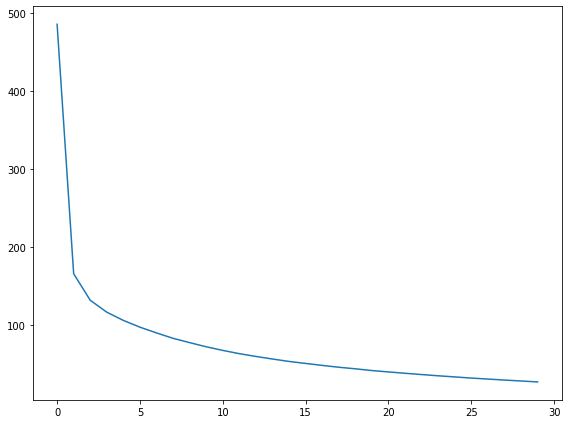

In [10]:
losses = []
epoch = 30
for i in range(epoch):
    sum_loss = 0
    for batch in iter(dataloader):
        X_, y_ = batch
        y_hat = model(X_)
        loss = loss_function(y_hat, y_.long())
        optim.zero_grad()
        loss.backward()
        optim.step()
        sum_loss += loss.item()
    losses.append(sum_loss)
    if (i + 1) % 5 == 0 or i == 0:
        print("Episode:", i+1, "Loss:", sum_loss)

plt.figure(figsize=(8, 6))
plt.plot(list(range(epoch)), losses)
plt.tight_layout()
plt.show()

Нарисуем confusion matrix. Компонента (i, j) показывает сколько элементов i были предсказаны как j.

In [11]:
def predict(X):
    X = torch.Tensor(X).float()
    y_hat = F.softmax(model(X), 1).detach().numpy()
    return np.argmax(y_hat, axis=1), y_hat

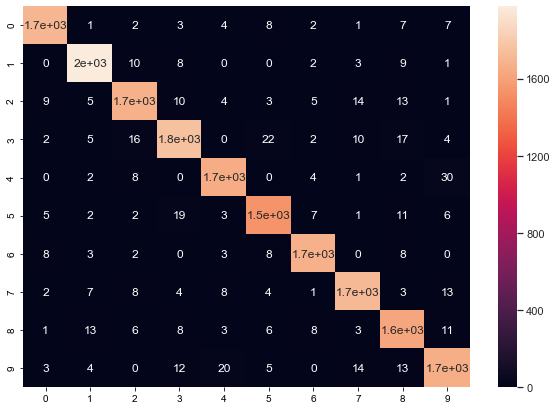

In [12]:
y_pred, _ = predict(X_test)

cm = confusion_matrix(y_test, y_pred )
df_cm = pd.DataFrame(cm, range(10), range(10))
plt.figure(figsize=(10,7))
plt.xlabel('predicted')
plt.ylabel('actual')
sn.set(font_scale=1) # for label size
sn.heatmap(df_cm, annot=True) 

plt.show()

In [13]:
print("точность на тесте =", np.sum(predict(X_test)[0] == y_test) / len(y_test))

точность на тесте = 0.97


In [14]:
def fast_adversarial_example(dig, n=784, n_classes=10, eta=0.01, iters=10):
    y = torch.tensor([dig]).long()
    x = torch.tensor(np.random.normal(loc=0, scale=0.01, size=n)).float()
    for _ in range(iters):      
        x = Variable(x.data.clone(), requires_grad=True)
        y_hat = model(x).unsqueeze(0)
        loss = loss_function(y_hat,y)
        model.zero_grad()
        loss.backward()
        grad = x.grad.data
        x = torch.clamp(x - eta*grad.sign(), 0, 1)
    return x

In [15]:
example = fast_adversarial_example(8, eta=0.1, iters=5)

In [16]:
alpha = 0.5
X_spoiled = np.maximum(X_test*(1-alpha), alpha*example.detach().numpy())
y_test_model, _ = predict(X_spoiled)

In [17]:
print("точность после атаки =", np.sum(predict(X_spoiled)[0] == y_test) / len(y_test))

точность после атаки = 0.09925714285714286


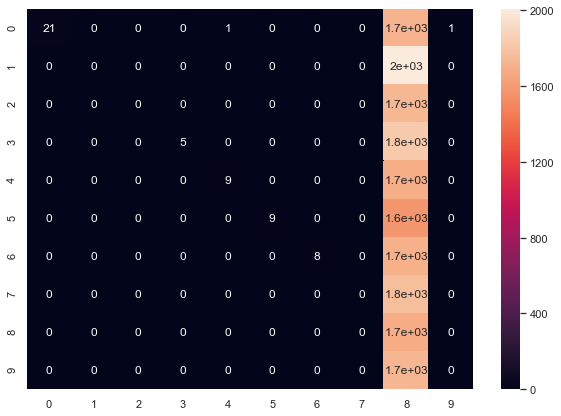

In [18]:
cm = confusion_matrix(y_test, y_test_model)
df_cm = pd.DataFrame(cm, range(10), range(10))
plt.figure(figsize=(10,7))
plt.xlabel('predicted')
plt.ylabel('actual')
sn.set(font_scale=1) # for label size
sn.heatmap(df_cm, annot=True)

plt.show()

In [19]:
x_target = np.array([X_spoiled[0]])


In [20]:
y_pred, score = predict(x_target)

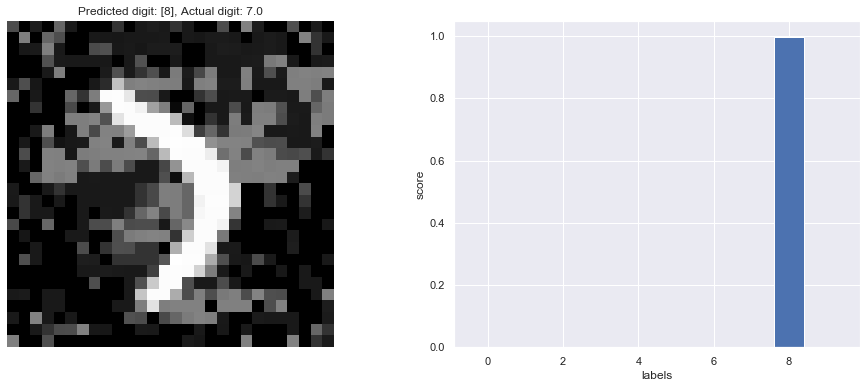

In [21]:
plt.figure(figsize=(16, 6))

plt.subplot(121)
pixels = x_target.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.title(f'Predicted digit: {y_pred}, Actual digit: {y_test[0]}')
plt.axis('off')

plt.subplot(122)
plt.bar(range(10), score[0])
plt.ylabel('score')
plt.xlabel('labels')

plt.show()